### **Add pre-installed package path & load packages:**

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [2]:
library("dplyr", warn.conflicts = F)
library("tidyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
#library(survival)

### **Change working directory:**

In [3]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium"

### **Load data:**

#### Unadjusted proteomics

In [58]:
# unadjusted proteome file
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/Resource/Proteome/no_batch7/proteome_unadjusted.txt"
prot <- fread(file) %>% as_tibble
# change "-" to "_" in some column names
prot <- rename_with(prot, ~ gsub("-", "_", .x))
dim(prot)
head(prot)

[1] 32746  2951

FID,IID,Sex,Age,GeneticArray,UKB_centre,protein_batch,Sample_age,PC_1,PC_2,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1331483,1331483,1,54,1,11012,0,4612,-11.1120,4.32787,⋯,0.4039,-0.4125,-0.09345,-0.76265,-0.24295,-0.0419,-0.07065,-0.3355,-0.18575,0.48245
1361634,1361634,1,44,1,11010,0,5076,-13.6785,5.88845,⋯,0.0299,-0.2598,0.18405,-0.43495,3.28595,-0.2007,0.54375,-0.8688,0.28305,1.16465
1508802,1508802,0,54,1,11010,0,5076,-12.9177,6.97354,⋯,-0.8821,0.3132,0.03755,-0.32695,0.25825,-0.5867,-0.70445,1.1548,-0.33145,1.07485
1533247,1533247,1,58,1,11011,0,4982,-11.5671,3.51090,⋯,-1.6311,0.1698,-0.05835,-0.32865,0.17085,-0.6857,-1.00975,-0.4541,-0.01685,0.21385
1629003,1629003,0,61,1,11016,0,4575,-12.5582,5.42726,⋯,-0.1456,0.2485,0.85035,1.84065,0.18675,0.0550,-0.64625,-0.3087,-0.38505,-0.09005
1629466,1629466,0,58,1,11001,0,5342,-13.1117,2.61686,⋯,-0.8135,-0.1235,-0.71715,0.88495,0.41565,-0.7310,-0.02125,-0.8497,-0.01975,2.73195


#### Phenotypes 

In [59]:
# prelim pheno file
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/Resource/pheno/delirium.phe"
phe <- fread(file)
phe %>% nrow
phe %>% pull(delirium) %>% table

[1] 407909

.
     0      1 
400386   7523 

In [60]:
# apoe e4 count
file = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/ukb_wb_del_cov_phe_dem_apoe.txt"
apoe <- fread(file, select = c("IID", "e4_count"))
phe  <- left_join(phe, apoe, by = "IID")

In [61]:
## dementia outcomes
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/extra_data/dementia_outcomes.csv"
dem  <- fread(file)
## select only "Date of all cause dementia report"; field 42018
dem    <- dem %>% select(eid, `42018-0.0`) %>% filter(`42018-0.0` != "1900-01-01") %>% rename("dementia_date" = `42018-0.0`)
phe    <- left_join(phe, dem, by = c("IID"="eid")) # merge with main dataset based on "eid"

In [62]:
# BMI 
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/extra_data/f21001.BMI.csv"
bmi  <- fread(file) %>% select(eid, `21001-0.0`) %>% rename("BMI" = `21001-0.0`)
phe  <- left_join(phe, bmi, by = c("IID"="eid"))

#### Metadata

In [63]:
# assay table 
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/proteomics/olink_assay.dat"
assay <- fread(file)
# replace "-" with "_" in assay (protein) names
assay <- assay %>% mutate(Assay = gsub("-", "_", Assay))

In [64]:
# genomic positions table
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/Resource/Proteome/Sun_etal_sup/proteins_positions.txt"
pos  <- fread(file)

In [65]:
pos <-
pos %>% 
    mutate(UniProt = gsub(";.*","",UniProt)) %>%
    mutate(Gene_CHROM = gsub(";.*","",Gene_CHROM)) %>%
    mutate(Gene_start = gsub(";.*","",Gene_start))%>% 
    mutate(Gene_end = gsub(";.*","",Gene_end)) %>%
    filter(!duplicated(UniProt))


### **Exclude withdrawls**

In [66]:
w_eids <- fread("/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/withdraw44986_131_20231013.txt")
w_eids <- w_eids$V1
phe    <- phe %>% filter(!(IID %in% w_eids))

### **Make delirium_incident cases outcome, if delirium case reported after 1 year of assessment:**

In [67]:
# incident delirium: 1
# prevalent delirium: -1 (to be excluded)
# control: 0

phe <- 
phe %>% 
    mutate(delirium_incident = case_when((age >= approx_AAA+1 & delirium==1) ~  1, # incident case
                                        (age < approx_AAA+1 & delirium==1) ~ -1,  # prevalent case
                                        (delirium==0)~0, # control
                                         TRUE ~ NA)) 
phe %>% pull(delirium_incident) %>% table(.,useNA = "ifany")
head(phe)

.
    -1      0      1 
    75 400386   7448 

FID,IID,sex,age,approx_dob,approx_AAA,age_death,delirium_date,censoring_date,delirium,e4_count,dementia_date,BMI,delirium_incident
<int>,<int>,<int>,<dbl>,<IDate>,<dbl>,<dbl>,<IDate>,<IDate>,<int>,<int>,<IDate>,<dbl>,<dbl>
1000015,1000015,1,82.0,1940-11-15,67.44,NA,NA,2022-10-31,0,1,NA,24.6832,0
1000027,1000027,1,76.1,1946-09-15,61.85,NA,NA,2022-10-31,0,1,NA,32.5577,0
1000039,1000039,0,69.0,1953-10-15,55.14,NA,NA,2022-10-31,0,0,NA,19.8903,0
1000040,1000040,1,56.6,1966-03-15,42.47,NA,NA,2022-10-31,0,0,NA,30.1242,0
1000053,1000053,0,54.7,1968-02-15,41.04,NA,NA,2022-10-31,0,2,NA,22.2860,0
1000064,1000064,0,58.6,1964-03-15,46.49,NA,NA,2022-10-31,0,0,NA,44.3343,0


### Make dementia_prevalent covariate:

In [50]:
# dementia_prevalent: 
# 1 = dementia at assessment + 1 year burn in period after assessment (prevalent); 
# 0 = after delirium (incident) OR no delirium / dementia

phe2 <-
phe %>%
    # dementia_age variable
    mutate(dementia_age = round(as.numeric(difftime(dementia_date, approx_dob, units="days")) / 365.25, digits=1)) %>%
    # dementia prior to assessment + 1 year
   mutate(dementia_prevalent = case_when(dementia_age <= approx_AAA+1  ~ 1, # prevalent
                                         dementia_age  > approx_AAA+1  ~ 0, # incident
                                         TRUE ~ 0)) 

phe2 %>% group_by(dementia_prevalent) %>% summarise(n=n())

# dementia prior to delirium (cases) / dementia any time (controls)
#    mutate(dementia_prevalent2 = case_when((as.IDate(dementia_date) <= as.IDate(delirium_date)) ~ 1, # prevalent
#                                           (as.IDate(dementia_date) >  as.IDate(delirium_date)) ~ 0, # incident
#                                            !is.na(dementia_date) ~ 1, # controls with dementia
#                                            is.na(dementia_date)  ~ 0, # controls without dementia
#                                            TRUE ~ NA)) 

dementia_prevalent,n
<dbl>,<int>
0,407694
1,215


In [ ]:
#library(lubridate)
## adds / substracts dates 
#phe %>% mutate(a = as.Date(dementia_date) %m-% years(1)) %>% select(dementia_date, a) %>% filter(!is.na(dementia_date))


In [69]:
# clean pheno table
phe2 <-
#phe2 %>% 
phe %>%
    filter(delirium_incident %in% c(0,1)) %>% # exclude prevalent delirium
#   mutate(dementia_prevalent = as.factor(dementia_prevalent)) %>% 
    rename(age_at_collection = "approx_AAA") %>%
#   select(IID,sex,age_at_collection,age,BMI,dementia_prevalent,delirium_incident)
    select(IID,sex,age_at_collection,age,BMI,e4_count,delirium_incident)
dim(phe2)
head(phe2)

[1] 407834      7

IID,sex,age_at_collection,age,BMI,e4_count,delirium_incident
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1000015,1,67.44,82.0,24.6832,1,0
1000027,1,61.85,76.1,32.5577,1,0
1000039,0,55.14,69.0,19.8903,0,0
1000040,1,42.47,56.6,30.1242,0,0
1000053,0,41.04,54.7,22.2860,2,0
1000064,0,46.49,58.6,44.3343,0,0


### Statistics on missingness:

In [70]:
# statistics on missingness
nmiss_id   <- prot[,-c(1:28)] %>% mutate(nmiss_id = rowSums(!is.na(.))/ncol(prot[,-c(1:28)]) ) %>% filter(nmiss_id>0.8) %>% nrow
nmiss_prot <- prot[,-c(1:28)] %>% summarise_all(funs(sum(!is.na(.))/nrow(prot[,-c(1:28)]))) %>% t %>% as.vector %>% .[.>0.8] %>% length

print(paste("Individuals with > 80% nonmissing values:", nmiss_id, "out of", nrow(prot[,-c(1:28)])))
print(paste("Proteins with > 80% nonmissing values:", nmiss_prot, "out of", ncol(prot[,-c(1:28)])))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


[1] "Individuals with > 80% nonmissing values: 32570 out of 32746"
[1] "Proteins with > 80% nonmissing values: 2919 out of 2923"


### **Merge phe + proteomics data:**

In [71]:
data <- inner_join(x=phe2, y=prot, by="IID") %>% select(-c('Age', 'Sex', 'FID')) 
dim(prot)
dim(data) # some missing from prot table: due to extra qc steps in extractF05.ipynb
head(data)


[1] 32746  2951

[1] 32652  2954

IID,sex,age_at_collection,age,BMI,e4_count,delirium_incident,GeneticArray,UKB_centre,protein_batch,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000071,0,59.17,74.3,27.3034,1,0,1,11004,3,⋯,-0.0404,0.0709,0.1207,0.3909,-0.2911,-0.22785,-0.3313,1.6562,0.0000,-0.6093
1000303,1,63.82,72.1,30.0092,0,0,0,11010,6,⋯,1.8926,-0.0241,0.5815,-0.1538,-0.2890,0.84655,0.1522,0.6625,0.3080,-0.2519
1000629,0,54.93,67.6,25.6935,0,0,0,11021,3,⋯,-0.5778,0.2080,0.1028,-0.2671,0.3807,-0.38695,0.3052,-4.3959,0.1463,0.4644
1000647,0,68.51,76.7,22.7918,0,0,1,11010,3,⋯,-0.8161,0.0691,-0.0001,0.0606,0.6231,-0.37185,-0.5297,0.8547,-0.0875,1.9491
1000757,0,57.94,72.2,25.6568,1,0,1,11011,2,⋯,1.0404,-0.1653,0.2392,-0.1405,0.4756,-0.21525,0.8643,2.0385,0.0294,0.0417
1000900,0,47.55,61.1,30.9234,0,0,1,11011,3,⋯,0.2752,0.1067,-0.1043,-0.1570,0.5793,-0.18945,-0.3761,0.1647,-0.2371,-0.6022


### **QC proteins with high missingness (>20%)**

In [72]:
n_prot     <- nrow(data[,-c(1:31)]) # #of proteins
prot_names <- names(data)[-c(1:31)] # protein names

## find proteins with < 80% nonmissing values

# produce table with % non-missing per protein
nmiss_prot <- data %>% select(all_of(prot_names)) %>% summarise(across(everything(), ~ sum(!is.na(.)) / n_prot)) 
# protein names with < 80% nonmissing values
low_nmiss_prot_names <-  names(nmiss_prot)[nmiss_prot <  0.8] 
cat("proteins with <80% non-missing rate to be excluded:", low_nmiss_prot_names)

# exlcude proteins with <80% non-missing rate
data_qc <- data %>% select(-c(all_of(low_nmiss_prot_names)))

proteins with <80% non-missing rate to be excluded: CTSS GLIPR1 NPM1 PCOLCE

### **Statistics on delirium phenotype:**

In [55]:
## overall cases count
data_qc %>% 
    group_by(dementia_prevalent) %>% 
#   group_by(delirium_incident, dementia_prevalent) 
    summarise(n=n()) %>% 
    mutate(percent = format(n/sum(n)*100,digits = 2))

dementia_prevalent,n,percent
<fct>,<int>,<chr>
0,32638,99.957
1,14,0.043


In [73]:
## overall cases count
data_qc %>% 
    group_by(delirium_incident) %>% 
#   group_by(delirium_incident, dementia_prevalent) 
    summarise(n=n()) %>% 
    mutate(percent = format(n/sum(n)*100,digits = 2))

delirium_incident,n,percent
<dbl>,<int>,<chr>
0,32111,98.3
1,541,1.7


delirium_incident,PC_20,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,32111,32111,32111,31945,32111,31831,31945,32111,32111,⋯,32111,32111,32111,32111,32111,32111,32111,32111,32111,32111
1,541,541,541,533,541,531,533,541,541,⋯,541,541,541,541,541,541,541,541,541,541


[1] "No. of delirium cases summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  466.0   532.0   533.0   535.5   541.0   541.0 

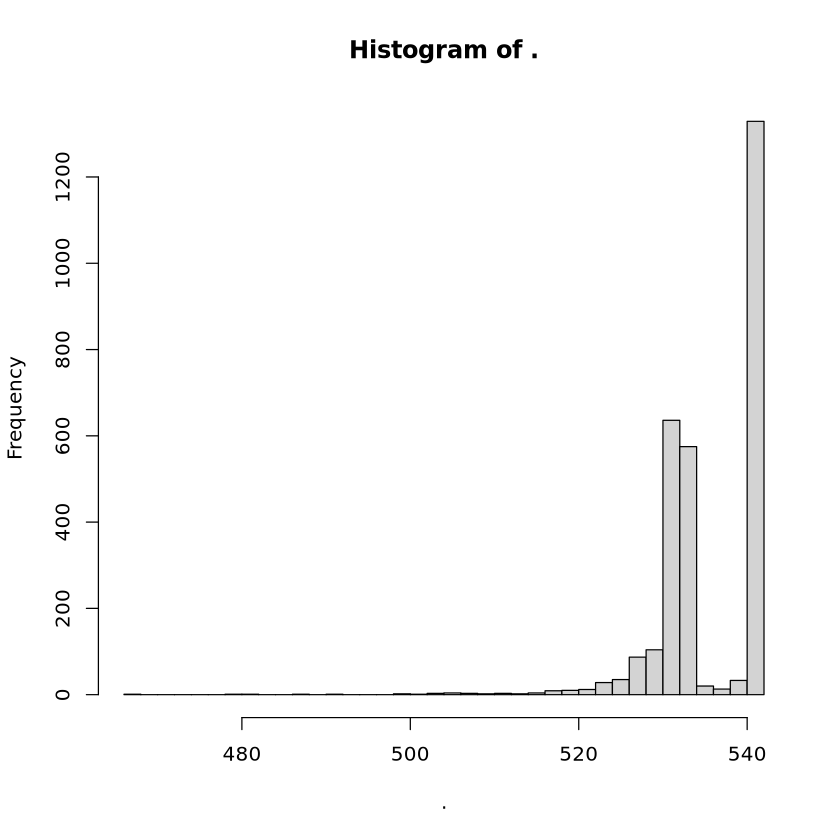

In [74]:
## per protein cases count 
# make table with ncases / ncontrols per protein - will use later
del_per_prot <- data_qc[,-c(1:6,8:30)] %>% group_by(delirium_incident) %>% summarise(across(where(is.numeric), ~ sum(!is.na(.))))
del_per_prot
# hist
del_per_prot[2,-1] %>% t %>% hist(.,breaks=50)
# summary
print("No. of delirium cases summary:")
del_per_prot[,-1] %>% t %>% .[,2] %>% summary

### Exclude proteins with <150 delirium cases:

In [75]:
# transpose del_per_prot table & filter proteins with < 150 cases
prot_names_low_cases <-
    tibble(prot = colnames(del_per_prot[,-1]), 
           n_cases = as.numeric(del_per_prot[2,-1]), 
           n_controls = as.numeric(del_per_prot[1,-1])) %>%
    filter(n_cases < 150) %>% pull(prot)

cat(paste0("Proteins to be excluded:", "\n", paste(prot_names_low_cases, collapse = "\n")))

# filter out proteins to be excluded
data_qc <- data_qc %>% select(!any_of(prot_names_low_cases))

Proteins to be excluded:


### **Inverse-rank normalisation of proteins:**

In [23]:
# protein names
prot_names <- names(data_qc)[32:ncol(data_qc)]  # skip all covariates (check first)

# i.r.n.t. for every protein in prot_names
# data_int <-
data_qc <- 
data_qc %>% mutate(across(all_of(prot_names), ~ (qnorm((rank(.,na.last="keep")-0.5)/sum(!is.na(.))))))

In [ ]:
#test irnt
#a <- data_int %>% pull(ABHD14B) 
#b <- data %>% mutate(ABHD14B = qnorm((rank(ABHD14B,na.last="keep")-0.5)/sum(!is.na(ABHD14B))) ) %>% pull(ABHD14B)
#data.frame(a,b) %>% filter(is.na(a))
#all(a==b,na.rm = T)

### **Check significant covariates:**

In [22]:
PC1to20   <- paste0("PC_", seq(1,20), collapse=" + ")
formula0  <- 
as.formula(
    paste(
    "delirium_incident ~ sex + age_at_collection + BMI + GeneticArray + UKB_centre + protein_batch + Sample_age + e4_count",
    #PC1to20,
    sep=" + "))
print(formula0)
mod0 <- glm(formula = formula0, data = data_qc, family="binomial")
summary(mod0)
## keep sex, age_at_collection, BMI  

delirium_incident ~ sex + age_at_collection + BMI + GeneticArray + 
    UKB_centre + protein_batch + Sample_age + e4_count


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = formula0, family = "binomial", data = data_qc)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -5.222e+02  2.039e+02  -2.561 0.010432 *  
sex                3.674e-01  8.858e-02   4.148 3.35e-05 ***
age_at_collection  1.732e-01  9.312e-03  18.603  < 2e-16 ***
BMI                4.563e-02  8.986e-03   5.078 3.82e-07 ***
GeneticArray       3.338e-02  1.409e-01   0.237 0.812779    
UKB_centre         4.543e-02  1.839e-02   2.471 0.013490 *  
protein_batch     -5.684e-02  3.120e-02  -1.822 0.068444 .  
Sample_age         1.191e-03  3.333e-04   3.574 0.000351 ***
e4_count           4.210e-01  7.776e-02   5.414 6.16e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5509.1  on 32641  degrees of freedom
Residual deviance: 4880.9  on 32633  degrees of freedom
  (10 observations deleted due to missingness)
AIC: 4898.9

Number of

### **Export clean data table (no extra covariates):**

In [66]:
data_clean <- data_qc %>% select(c("IID","delirium_incident","sex","age_at_collection","BMI","age","e4_count"),names(data_qc)[32:ncol(data_qc)])
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/data/data_int_clean.csv"
write.table(data_clean, file=file, sep = ",", row.names = F, col.names = T, quote = T)

In [4]:
## LOAD CLEAD DATA
file    <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/data/data_int_clean.csv"
data_qc <- fread(file)


### **Logistic Regression on full set:**

#### ***delirium ~ age + sex + BMI + protein_i***

In [ ]:
# real
# get protein names
noprot_names <- c('IID','delirium_incident','sex','age_at_collection','BMI','age','e4_count')
prot_names   <- names(data_qc)[names(data_qc)!=noprot_names]  # skip all covariates (check first)
# create empty output sumstats table
prot_sumstats <- data.frame(PROTEIN=numeric(), 
                            BETA=numeric(), 
                            STDERR=numeric(), 
                            PVALUE=numeric(), 
                            #PROTxE4=numeric(),
                            #PROTxE4_STDERR=numeric(),
                            #PROTxE4_PVALUE=numeric(),
                            NCASES=numeric(), 
                            NCONTROLS=numeric()
                           )
# assign dataframe 
data_for_loop = data_qc

# progress bar
pb = txtProgressBar(min = 0, max = length(prot_names), initial = 0) 

# run model: "incident delirium ~ covariates + protein" for each protein in prot_names
for (i in 1:length(prot_names)) {
    #print(paste0("analyzing protein ", prot_names[i], " ..."))
    ## create formula string
    formula_i  <- as.formula(
        paste(
            "delirium_incident ~ sex + age_at_collection + BMI + ", prot_names[i]))
    ## logistic reg model: delirium ~ coviates + protein_i
    mod_i   <- glm(formula = formula_i, data = data_for_loop, family="binomial",) %>% suppressWarnings()
    ## extract coefficients: beta; std error; p-value
    coefs_i <- summary(mod_i)$coefficients[prot_names[i],c("Estimate","Std. Error","Pr(>|z|)")] 
    ## append coefs in output sumstats table
    prot_sumstats[i,c("BETA","STDERR","PVALUE")] <- coefs_i
    ## append protein_i name in output sumstats table
    prot_sumstats[i,"PROTEIN"] <- prot_names[i]
    # ## append e4 interaction sumstats
    # prot_x_e4_i       <- paste0("e4_count:", prot_names[i])
    # prot_x_e4_coefs_i <- summary(mod_i)$coefficients[prot_x_e4_i,c("Estimate","Std. Error","Pr(>|z|)")]
    # prot_sumstats[i,c("PROTxE4","PROTxE4_STDERR","PROTxE4_PVALUE")] <- prot_x_e4_coefs_i
    ## append protein_i no. of cases + controls (using del_per_prot_train table)
    ncases    <- del_per_prot[2,prot_names[i]] # 2nd row: cases
    ncontrols <- del_per_prot[1,prot_names[i]] # 1st row: cases
    prot_sumstats[i,c("NCASES","NCONTROLS")] <- c(ncases, ncontrols)
    #print("Done")
    setTxtProgressBar(pb,i)
    cat(paste0("\rAnalysed ", i, " out of ",  length(prot_names), " proteins (", round((i / length(prot_names)*100),2), "%) ..."))
}


In [ ]:
prot_sumstats_annot <- inner_join(x=prot_sumstats, y=assay, by=c("PROTEIN"="Assay")) 
# make UniProt var to merge 
prot_sumstats_annot <- prot_sumstats_annot %>% mutate(UniProt2 = gsub("-.*","", UniProt)) %>% mutate(UniProt2 = gsub("_.*","", UniProt2))

prot_sumstats_annot_pos <- 
left_join(x=prot_sumstats_annot, y=pos[,-c("Assay_Target","Gene_symbol")], by=c("UniProt2"="UniProt")) %>% 
    mutate(Gene_CHROM = gsub("X","23",Gene_CHROM)) %>%
    mutate(Gene_CHROM = as.numeric(Gene_CHROM)) %>%
    mutate(Gene_start = as.numeric(Gene_start)) %>%
    mutate(Gene_end = as.numeric(Gene_end)) %>%
    arrange(Gene_CHROM, Gene_start)


In [ ]:
# output 
dim(prot_sumstats_annot_pos)
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05/nrow(prot_sumstats_annot_pos)) %>% nrow
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05/nrow(prot_sumstats_annot_pos)) %>% head

In [ ]:
# write output 
write.table(prot_sumstats_annot_pos, "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_sumstats.txt", sep = ",", row.names = F, col.names = T, quote = T)

#### ***delirium ~ age + sex + BMI + protein_i + APOE-e4 x protein interaction***

In [50]:
# real
# get protein names
prot_names <- names(data_qc)[32:ncol(data_qc)]  # skip all covariates (check first)
# create empty output sumstats table
prot_sumstats <- data.frame(PROTEIN=numeric(), 
                            BETA=numeric(), 
                            STDERR=numeric(), 
                            PVALUE=numeric(), 
                            PROTxE4=numeric(),
                            PROTxE4_STDERR=numeric(),
                            PROTxE4_PVALUE=numeric(),
                            NCASES=numeric(), 
                            NCONTROLS=numeric()
                           )
# progress bar
pb = txtProgressBar(min = 0, max = length(prot_names), initial = 0) 

# run model: "incident delirium ~ covariates + protein" for each protein in prot_names
for (i in 1:length(prot_names)) {
    #print(paste0("analyzing protein ", prot_names[i], " ..."))
    ## create formula string
    formula_i  <- as.formula(
        paste(
            "delirium_incident ~ sex + age_at_collection + BMI + e4_count*", prot_names[i]))
    ## logistic reg model: delirium ~ coviates + protein_i
    mod_i   <- glm(formula = formula_i, data = data_qc, family="binomial",) %>% suppressWarnings()
    ## extract coefficients: beta; std error; p-value
    coefs_i <- summary(mod_i)$coefficients[prot_names[i],c("Estimate","Std. Error","Pr(>|z|)")] 
    ## append coefs in output sumstats table
    prot_sumstats[i,c("BETA","STDERR","PVALUE")] <- coefs_i
    ## append protein_i name in output sumstats table
    prot_sumstats[i,"PROTEIN"] <- prot_names[i]
    ## append e4 interaction sumstats
    prot_x_e4_i       <- paste0("e4_count:", prot_names[i])
    prot_x_e4_coefs_i <- summary(mod_i)$coefficients[prot_x_e4_i,c("Estimate","Std. Error","Pr(>|z|)")]
    prot_sumstats[i,c("PROTxE4","PROTxE4_STDERR","PROTxE4_PVALUE")] <- prot_x_e4_coefs_i
    ## append protein_i no. of cases + controls (using del_per_prot_train table)
    ncases    <- del_per_prot[2,prot_names[i]] # 2nd row: cases
    ncontrols <- del_per_prot[1,prot_names[i]] # 1st row: cases
    prot_sumstats[i,c("NCASES","NCONTROLS")] <- c(ncases, ncontrols)
    #print("Done")
    setTxtProgressBar(pb,i)
    #cat(paste0("\rAnalysed ", i, " out of ",  length(prot_names), " proteins (", round((i / length(prot_names)*100),2), "%) ..."))
}


In [51]:
prot_sumstats_annot <- inner_join(x=prot_sumstats, y=assay, by=c("PROTEIN"="Assay")) 
# make UniProt var to merge 
prot_sumstats_annot <- prot_sumstats_annot %>% mutate(UniProt2 = gsub("-.*","", UniProt)) %>% mutate(UniProt2 = gsub("_.*","", UniProt2))

prot_sumstats_annot_pos <- 
left_join(x=prot_sumstats_annot, y=pos[,-c("Assay_Target","Gene_symbol")], by=c("UniProt2"="UniProt")) %>% 
    mutate(Gene_CHROM = gsub("X","23",Gene_CHROM)) %>%
    mutate(Gene_CHROM = as.numeric(Gene_CHROM)) %>%
    mutate(Gene_start = as.numeric(Gene_start)) %>%
    mutate(Gene_end = as.numeric(Gene_end)) %>%
    arrange(Gene_CHROM, Gene_start)


In [56]:
# output 
dim(prot_sumstats_annot_pos)
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05/nrow(prot_sumstats_annot_pos)) %>% nrow
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05/nrow(prot_sumstats_annot_pos)) %>% head

[1] 2919   15

[1] 39

,PROTEIN,BETA,STDERR,PVALUE,PROTxE4,PROTxE4_STDERR,PROTxE4_PVALUE,NCASES,NCONTROLS,UniProt,Panel,UniProt2,Gene_CHROM,Gene_start,Gene_end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,GDF15,0.4423138,0.06574961,1.729034e-11,0.0170975958,0.08780006,0.8456017,532,31884,Q99988,Cardiometabolic,Q99988,19,18374731,18389176
2,AREG,0.3627137,0.05944031,1.046507e-09,-0.0002928142,0.08522372,0.9972586,533,31945,P15514,Oncology,P15514,4,74445136,74455005
3,WFDC2,0.3716657,0.06143184,1.448009e-09,0.0987329458,0.08681397,0.2554157,513,30513,Q14508,Oncology,Q14508,20,45469753,45481532
4,IL6,0.3412059,0.05893360,7.052633e-09,-0.0064074146,0.08030888,0.9364085,533,31945,P05231,Oncology,P05231,7,22725884,22732002
5,TFF3,0.3444147,0.06101244,1.651901e-08,-0.0550779872,0.08438667,0.5139588,527,31636,Q07654,Cardiometabolic,Q07654,21,42311667,42315409
6,PLAUR,0.3223726,0.05834944,3.297437e-08,0.0303127498,0.08344665,0.7164114,520,31512,Q03405,Inflammation,Q03405,19,43646095,43670547


In [66]:
# write output 
write.table(prot_sumstats_annot_pos, "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_e4int_sumstats.txt", sep = ",", row.names = F, col.names = T, quote = T)

#### ***delirium ~ age + sex + BMI + protein_i + APOE protein x protein interaction***

In [34]:
# real
# get protein names
prot_names <- names(data_qc)[32:ncol(data_qc)]  # skip all covariates (check first)
# create empty output sumstats table
prot_sumstats <- data.frame(PROTEIN=numeric(), 
                            BETA=numeric(), 
                            STDERR=numeric(), 
                            PVALUE=numeric(), 
                            PROTxAPOE=numeric(),
                            PROTxAPOE_STDERR=numeric(),
                            PROTxAPOE_PVALUE=numeric(),
                            NCASES=numeric(), 
                            NCONTROLS=numeric()
                           )
# progress bar
pb = txtProgressBar(min = 0, max = length(prot_names), initial = 0) 

# run model: "incident delirium ~ covariates + protein" for each protein in prot_names
for (i in 1:length(prot_names)) {
#for (i in 1:2) {
    #print(paste0("analyzing prlibrary(rhdf5)otein ", prot_names[i], " ..."))
    ## skip APOE gene itself
    if (prot_names[i]=="APOE") next
    ## create formula string
    formula_i  <- as.formula(
        paste(
            "delirium_incident ~ sex + age_at_collection + BMI + APOE*", prot_names[i]))
    ## logistic reg model: delirium ~ coviates + protein_i
    mod_i   <- glm(formula = formula_i, data = data_qc, family="binomial",) %>% suppressWarnings()
    ## extract coefficients: beta; std error; p-value
    coefs_i <- summary(mod_i)$coefficients[prot_names[i],c("Estimate","Std. Error","Pr(>|z|)")] 
    ## append coefs in output sumstats table
    prot_sumstats[i,c("BETA","STDERR","PVALUE")] <- coefs_i
    ## append protein_i name in output sumstats table
    prot_sumstats[i,"PROTEIN"] <- prot_names[i]
    ## append APOE interaction sumstats
    prot_x_APOE_i       <- paste0("APOE:", prot_names[i])
    prot_x_APOE_coefs_i <- summary(mod_i)$coefficients[prot_x_APOE_i,c("Estimate","Std. Error","Pr(>|z|)")]
    prot_sumstats[i,c("PROTxAPOE","PROTxAPOE_STDERR","PROTxAPOE_PVALUE")] <- prot_x_APOE_coefs_i
    ## append protein_i no. of cases + controls (using del_per_prot_train table)
    ncases    <- del_per_prot[2,prot_names[i]] # 2nd row: cases
    ncontrols <- del_per_prot[1,prot_names[i]] # 1st row: cases
    prot_sumstats[i,c("NCASES","NCONTROLS")] <- c(ncases, ncontrols)
    #print("Done")
    setTxtProgressBar(pb,i)
    #cat(paste0("\rAnalysed ", i, " out of ",  length(prot_names), " proteins (", round((i / length(prot_names)*100),2), "%) ..."))
}


In [35]:
prot_sumstats_annot <- inner_join(x=prot_sumstats, y=assay, by=c("PROTEIN"="Assay")) 
# make UniProt var to merge 
prot_sumstats_annot <- prot_sumstats_annot %>% mutate(UniProt2 = gsub("-.*","", UniProt)) %>% mutate(UniProt2 = gsub("_.*","", UniProt2))

prot_sumstats_annot_pos <- 
left_join(x=prot_sumstats_annot, y=pos[,-c("Assay_Target","Gene_symbol")], by=c("UniProt2"="UniProt")) %>% 
    mutate(Gene_CHROM = gsub("X","23",Gene_CHROM)) %>%
    mutate(Gene_CHROM = as.numeric(Gene_CHROM)) %>%
    mutate(Gene_start = as.numeric(Gene_start)) %>%
    mutate(Gene_end = as.numeric(Gene_end)) %>%
    arrange(Gene_CHROM, Gene_start)


In [40]:
# output 
dim(prot_sumstats_annot_pos)
prot_sumstats_annot_pos %>% arrange(PROTxAPOE_PVALUE) %>% head

[1] 2918   15

,PROTEIN,BETA,STDERR,PVALUE,PROTxAPOE,PROTxAPOE_STDERR,PROTxAPOE_PVALUE,NCASES,NCONTROLS,UniProt,Panel,UniProt2,Gene_CHROM,Gene_start,Gene_end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,PIGR,0.27759302,0.04709221,3.754331e-09,0.1652197,0.04063106,4.775737e-05,523,31407,P01833,Neurology,P01833,1,206928522,206946466
2,CXADR,0.13578651,0.04537316,2.765561e-03,0.1470047,0.04102426,3.392034e-04,533,31945,P78310,Inflammation,P78310,21,17513043,17593579
3,GGT1,0.16073518,0.04945694,1.154039e-03,0.1395505,0.04017910,5.142720e-04,531,31833,P19440,Neurology,P19440,22,24594811,24629005
4,FDX1,0.04253069,0.04564553,3.514605e-01,0.1500576,0.04409584,6.665338e-04,541,32111,P10109,Cardiometabolic II,P10109,11,110429948,110464884
5,OFD1,-0.01925345,0.04425663,6.635326e-01,-0.1430894,0.04334138,9.618668e-04,541,32111,O75665,Oncology II,O75665,23,13734743,13777955
6,DEFB103A_DEFB103B,-0.04728862,0.04489113,2.921546e-01,-0.1301655,0.04009102,1.167312e-03,526,31865,P81534,Inflammation II,P81534,8,7428888,7430348


In [36]:
# write output 
write.table(prot_sumstats_annot_pos, "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_APOEint_sumstats.txt", sep = ",", row.names = F, col.names = T, quote = T)

#### ***delirium ~ age + sex + BMI + APOE-e4***

In [47]:
# real
# get protein names
prot_names <- names(data_qc)[32:ncol(data_qc)]  # skip all covariates (check first)
# create empty output sumstats table
prot_sumstats <- data.frame(PROTEIN=numeric(), 
                            BETA=numeric(), 
                            STDERR=numeric(), 
                            PVALUE=numeric(), 
                            NCASES=numeric(), 
                            NCONTROLS=numeric()
                           )
# progress bar
pb = txtProgressBar(min = 0, max = length(prot_names), initial = 0) 

# run model: "incident delirium ~ covariates + protein" for each protein in prot_names
for (i in 1:length(prot_names)) {
#for (i in 1:2) {
    #print(paste0("analyzing prlibrary(rhdf5)otein ", prot_names[i], " ..."))
    ## create formula string
    formula_i  <- as.formula(
        paste(
            "delirium_incident ~ sex + age_at_collection + BMI + e4_count +", prot_names[i]))
    ## logistic reg model: delirium ~ coviates + protein_i
    mod_i   <- glm(formula = formula_i, data = data_qc, family="binomial",) %>% suppressWarnings()
    ## extract coefficients: beta; std error; p-value
    coefs_i <- summary(mod_i)$coefficients[prot_names[i],c("Estimate","Std. Error","Pr(>|z|)")] 
    ## append coefs in output sumstats table
    prot_sumstats[i,c("BETA","STDERR","PVALUE")] <- coefs_i
    ## append protein_i name in output sumstats table
    prot_sumstats[i,"PROTEIN"] <- prot_names[i]
    ## append protein_i no. of cases + controls (using del_per_prot_train table)
    ncases    <- del_per_prot[2,prot_names[i]] # 2nd row: cases
    ncontrols <- del_per_prot[1,prot_names[i]] # 1st row: cases
    prot_sumstats[i,c("NCASES","NCONTROLS")] <- c(ncases, ncontrols)
    #print("Done")
    setTxtProgressBar(pb,i)
    #cat(paste0("\rAnalysed ", i, " out of ",  length(prot_names), " proteins (", round((i / length(prot_names)*100),2), "%) ..."))
}


In [48]:
prot_sumstats_annot <- inner_join(x=prot_sumstats, y=assay, by=c("PROTEIN"="Assay")) 
# make UniProt var to merge 
prot_sumstats_annot <- prot_sumstats_annot %>% mutate(UniProt2 = gsub("-.*","", UniProt)) %>% mutate(UniProt2 = gsub("_.*","", UniProt2))

prot_sumstats_annot_pos <- 
left_join(x=prot_sumstats_annot, y=pos[,-c("Assay_Target","Gene_symbol")], by=c("UniProt2"="UniProt")) %>% 
    mutate(Gene_CHROM = gsub("X","23",Gene_CHROM)) %>%
    mutate(Gene_CHROM = as.numeric(Gene_CHROM)) %>%
    mutate(Gene_start = as.numeric(Gene_start)) %>%
    mutate(Gene_end = as.numeric(Gene_end)) %>%
    arrange(Gene_CHROM, Gene_start)


In [55]:
# output 
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05 / nrow(.)) %>% dim
prot_sumstats_annot_pos %>% arrange(PVALUE) %>% filter(PVALUE < 0.05 / nrow(.)) %>% head

[1] 111  12

,PROTEIN,BETA,STDERR,PVALUE,NCASES,NCONTROLS,UniProt,Panel,UniProt2,Gene_CHROM,Gene_start,Gene_end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,GDF15,0.4492583,0.05525540,4.272476e-16,532,31884,Q99988,Cardiometabolic,Q99988,19,18374731,18389176
2,WFDC2,0.4106737,0.05112292,9.506805e-16,513,30513,Q14508,Oncology,Q14508,20,45469753,45481532
3,AREG,0.3625946,0.04828552,5.940508e-14,533,31945,P15514,Oncology,P15514,4,74445136,74455005
4,IL6,0.3385499,0.04862260,3.335561e-12,533,31945,P05231,Oncology,P05231,7,22725884,22732002
5,PLAUR,0.3341755,0.04851640,5.662662e-12,520,31512,Q03405,Inflammation,Q03405,19,43646095,43670547
6,TFF3,0.3210395,0.04922193,6.924372e-11,527,31636,Q07654,Cardiometabolic,Q07654,21,42311667,42315409


In [56]:
# write output 
write.table(prot_sumstats_annot_pos, "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_e4Adj_sumstats.txt", sep = ",", row.names = F, col.names = T, quote = T)